## Model comparison notebook

by Xuan Fang in 2025

part of the manuscript "A Bayesian framework for systems model refinement and selection of calcium signaling"

In [2]:
import pickle 
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm
from pymc import Model, Normal, Slice, sample, traceplot
import numpy as np
from matplotlib import rcParams
from scipy.stats import lognorm
import statsmodels.api as sm
import sunode
from sunode.wrappers.as_pytensor import solve_ivp
import pandas as pd
from arviz.stats import stats
import pytensor

In [3]:
def minmax_scaling(ar):
    ar-=ar.min()
    ar/=ar.max()
    return ar

In [3]:
path='/home/xfang2/repos/bayes/data/inference_data/ca_uptake'
K=3
# dummy variables
nCells=7
normalize=True
ts=np.linspace(0,1,10)

In [5]:
# model1
y0s=[0,0,0]

def dydt1(t,y,params):
    dATPdt = - params.r * y.atp
    dopdt = 1 / (1 + params.Kdatp / y.atp) - params.v * y.op
    dcaIndt = params.caEx * params.g * y.op + params.kleak * (0.1 - y.caIn)

    return {
            'atp': dATPdt,
            'op': dopdt,
            'caIn': dcaIndt}

with pm.Model() as model1:
    # weight
    w=pm.Dirichlet('w', a=np.ones(K))

    # Hyperparams
    mu_Kdatp = pm.Lognormal('mu_Kdatp', mu=pm.math.log(0.5), sigma=1e-1, shape=K) 
    mu_r = pm.Lognormal('mu_r', mu=pm.math.log(4.0e-2), sigma=1e-1, shape=K) 
    mu_v = pm.Lognormal('mu_v', mu=pm.math.log(0.5), sigma=1e-1, shape=K)
    mu_g = pm.Lognormal('mu_g', mu=pm.math.log(5.0e-2), sigma=1e-1, shape=K)
    mu_kleak = pm.Lognormal('mu_kleak', mu=pm.math.log(0.3), sigma=1e-1, shape=K) 

    sigma_Kdatp = pm.HalfNormal('sigma_Kdatp', sigma=1e-1, shape=K)
    sigma_r = pm.HalfNormal('sigma_r', sigma=1e-1, shape=K)
    sigma_v = pm.HalfNormal('sigma_v', sigma=1e-1, shape=K)
    sigma_g = pm.HalfNormal('sigma_g', sigma=1e-1, shape=K)
    sigma_kleak = pm.HalfNormal('sigma_kleak', sigma=1e-1, shape=K)

    Kdatp_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_Kdatp), sigma=sigma_Kdatp, shape=K)
    r_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_r), sigma=sigma_r, shape=K)
    v_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_v), sigma=sigma_v, shape=K)
    g_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_g), sigma=sigma_g, shape=K)
    kleak_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kleak), sigma=sigma_kleak, shape=K)

    Kdatp = pm.Mixture('Kdatp', w=w, comp_dists=Kdatp_lognormal_dist, shape=nCells)
    r = pm.Mixture('r', w=w, comp_dists=r_lognormal_dist, shape=nCells)
    v = pm.Mixture('v', w=w, comp_dists=v_lognormal_dist, shape=nCells)
    g = pm.Mixture('g', w=w, comp_dists=g_lognormal_dist, shape=nCells)
    kleak = pm.Mixture('kleak', w=w, comp_dists=kleak_lognormal_dist, shape=nCells)      

    # initial values
    y0s_pm={'atp': (np.repeat(0,nCells), (nCells,)),
    'op': (np.repeat(0, nCells), (nCells,)),
    'caIn': (y0s, (nCells,))}

    # params
    caExs=np.repeat(0, nCells)
    params = {'Kdatp': (Kdatp, (nCells)),
        'r': (r, (nCells)),
        'v': (v, (nCells)),
        'g': (g, (nCells)),
        'kleak': (kleak, (nCells)),
        'caEx': (caExs, (nCells)), # fixed param
        }

    # running simulations of proposed param sets
    solution, _, problem, solver, _, _ = solve_ivp(
    y0=y0s_pm,
    params=params,
    rhs=dydt1,
    tvals=ts,
    t0=ts[0],)                
    sim = pm.Deterministic('sim', solution['caIn'])     

    if normalize:
        # pytensor.map does not specify dimension specification. So we need to do transpose back and forth
        sim=sim.T
        sim,_ = pytensor.map(fn=minmax_scaling, sequences=sim)
        sim=sim.T     

trace1=az.from_netcdf(path+'/model1_trace_sim.nc')


In [6]:
# model2
y0s=[0,0,0]

def dydt2(t,y,params):
    dATPdt = - params.r * y.atp
    dcaIndt = params.caEx * params.g * y.atp + params.kleak * (0.1 - y.caIn)

    return {
            'atp': dATPdt,
            'caIn': dcaIndt}

with pm.Model() as model2:
    # weight
    w=pm.Dirichlet('w', a=np.ones(K))

    # Hyperparams
    mu_r = pm.Lognormal('mu_r', mu=pm.math.log(4.0e-2), sigma=1e-1, shape=K) 
    mu_g = pm.Lognormal('mu_g', mu=pm.math.log(5.0e-2), sigma=1e-1, shape=K) 
    mu_kleak = pm.Lognormal('mu_kleak', mu=pm.math.log(0.3), sigma=1e-1, shape=K) 

    sigma_r = pm.HalfNormal('sigma_r', sigma=1e-1, shape=K)
    sigma_g = pm.HalfNormal('sigma_g', sigma=1e-1, shape=K)
    sigma_kleak = pm.HalfNormal('sigma_kleak', sigma=1e-1, shape=K)

    r_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_r), sigma=sigma_r, shape=K)
    g_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_g), sigma=sigma_g, shape=K)
    kleak_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kleak), sigma=sigma_kleak, shape=K)

    r = pm.Mixture('r', w=w, comp_dists=r_lognormal_dist, shape=nCells)
    g = pm.Mixture('g', w=w, comp_dists=g_lognormal_dist, shape=nCells)
    kleak = pm.Mixture('kleak', w=w, comp_dists=kleak_lognormal_dist, shape=nCells)      

    # initial values
    y0s_pm={'atp': (np.repeat(0,nCells), (nCells,)),
    'caIn': (y0s, (nCells,))}

    # params
    caExs=np.repeat(0, nCells)
    params = {
        'r': (r, (nCells)),
        'g': (g, (nCells)),
        'kleak': (kleak, (nCells)),
        'caEx': (caExs, (nCells)), # fixed param
        }

    # running simulations of proposed param sets
    solution, _, problem, solver, _, _ = solve_ivp(
    y0=y0s_pm,
    params=params,
    rhs=dydt2,
    tvals=ts,
    t0=ts[0],)                
    sim = pm.Deterministic('sim', solution['caIn'])     

    if normalize:
        # pytensor.map does not specify dimension specification. So we need to do transpose back and forth
        sim=sim.T
        sim,_ = pytensor.map(fn=minmax_scaling, sequences=sim)
        sim=sim.T     

trace2=az.from_netcdf(path+'/model2_trace_sim.nc')


In [7]:
# model3
y0s=[0,0,0]

def dydt3(t,y,params):
    dATPdt = - params.r * y.atp
    dopdt = params.Vmatp / (1 + params.Kdatp / y.atp) - params.Vmop / (1 + params.Kdop / y.op)
    dcaIndt = params.caEx * params.g * y.op + params.kleak * (0.1 - y.caIn)

    return {
            'atp': dATPdt,
            'op': dopdt,
            'caIn': dcaIndt}

with pm.Model() as model3:
    # weight
    w=pm.Dirichlet('w', a=np.ones(K))

    # Hyperparams
    mu_Kdatp = pm.Lognormal('mu_Kdatp', mu=pm.math.log(0.5), sigma=1e-1, shape=K) 
    mu_r = pm.Lognormal('mu_r', mu=pm.math.log(4.0e-2), sigma=1e-1, shape=K) 
    mu_g = pm.Lognormal('mu_g', mu=pm.math.log(5.0e-2), sigma=1e-1, shape=K)
    mu_kleak = pm.Lognormal('mu_kleak', mu=pm.math.log(0.3), sigma=1e-1, shape=K) 
    mu_Kdop = pm.Lognormal('mu_Kdop', mu=pm.math.log(0.2), sigma=1e-1, shape=K) 
    mu_Vmatp = pm.Lognormal('mu_Vmatp', mu=pm.math.log(0.7), sigma=1e-1, shape=K) 
    mu_Vmop = pm.Lognormal('mu_Vmop', mu=pm.math.log(0.6), sigma=1e-1, shape=K) 

    sigma_Kdatp = pm.HalfNormal('sigma_Kdatp', sigma=1e-1, shape=K)
    sigma_r = pm.HalfNormal('sigma_r', sigma=1e-1, shape=K)
    sigma_g = pm.HalfNormal('sigma_g', sigma=1e-1, shape=K)
    sigma_kleak = pm.HalfNormal('sigma_kleak', sigma=1e-1, shape=K)
    sigma_Kdop = pm.HalfNormal('sigma_Kdop', sigma=1e-1, shape=K)
    sigma_Vmatp = pm.HalfNormal('sigma_Vmatp', sigma=1e-1, shape=K)
    sigma_Vmop = pm.HalfNormal('sigma_Vmop', sigma=1e-1, shape=K)

    Kdatp_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_Kdatp), sigma=sigma_Kdatp, shape=K)
    r_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_r), sigma=sigma_r, shape=K)
    g_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_g), sigma=sigma_g, shape=K)
    kleak_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_kleak), sigma=sigma_kleak, shape=K)
    Kdop_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_Kdop), sigma=sigma_Kdop, shape=K)
    Vmatp_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_Vmatp), sigma=sigma_Vmatp, shape=K)
    Vmop_lognormal_dist= pm.Lognormal.dist(mu=pm.math.log(mu_Vmop), sigma=sigma_Vmop, shape=K)

    Kdatp = pm.Mixture('Kdatp', w=w, comp_dists=Kdatp_lognormal_dist, shape=nCells)
    r = pm.Mixture('r', w=w, comp_dists=r_lognormal_dist, shape=nCells)
    g = pm.Mixture('g', w=w, comp_dists=g_lognormal_dist, shape=nCells)
    kleak = pm.Mixture('kleak', w=w, comp_dists=kleak_lognormal_dist, shape=nCells)    
    Kdop = pm.Mixture('Kdop', w=w, comp_dists=Kdop_lognormal_dist, shape=nCells)
    Vmatp = pm.Mixture('Vmatp', w=w, comp_dists=Vmatp_lognormal_dist, shape=nCells)
    Vmop = pm.Mixture('Vmop', w=w, comp_dists=Vmop_lognormal_dist, shape=nCells)

    # initial values
    y0s_pm={'atp': (np.repeat(0,nCells), (nCells,)),
    'op': (np.repeat(0, nCells), (nCells,)),
    'caIn': (y0s, (nCells,))}

    # params
    caExs=np.repeat(0, nCells)
    params = {'Kdatp': (Kdatp, (nCells)),
        'r': (r, (nCells)),
        'g': (g, (nCells)),
        'kleak': (kleak, (nCells)),
        'caEx': (caExs, (nCells)), # fixed param
        'Kdop': (Kdop, (nCells)),
        'Vmatp': (Vmatp, (nCells)),
        'Vmop': (Vmop, (nCells)),
        }

    # running simulations of proposed param sets
    solution, _, problem, solver, _, _ = solve_ivp(
    y0=y0s_pm,
    params=params,
    rhs=dydt3,
    tvals=ts,
    t0=ts[0],)                
    sim = pm.Deterministic('sim', solution['caIn'])     

    if normalize:
        # pytensor.map does not specify dimension specification. So we need to do transpose back and forth
        sim=sim.T
        sim,_ = pytensor.map(fn=minmax_scaling, sequences=sim)
        sim=sim.T     

trace3=az.from_netcdf(path+'/model3_trace_sim.nc')


In [8]:
valName={'WAIC':'elpd_waic','loo':'elpd_loo'}
ic='loo'

/home/xfang2/anaconda3/envs/sunode-env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/xfang2/anaconda3/envs/sunode-env/lib/python3.10/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


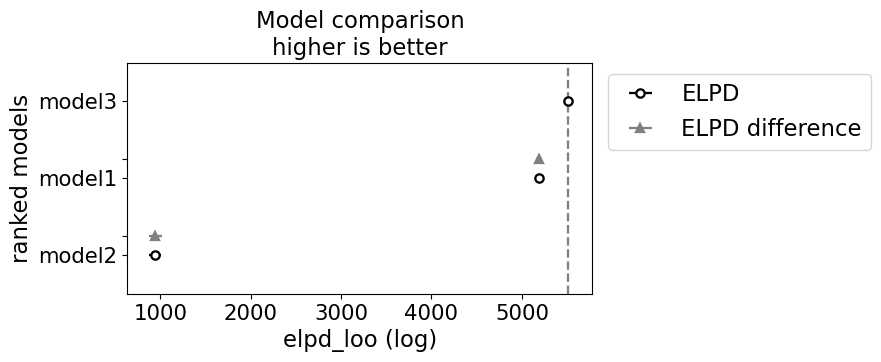

In [9]:
# WAIC
nModels=3
idata1=stats.convert_to_inference_data(trace1,model=model1)
idata2=stats.convert_to_inference_data(trace2,model=model2)
idata3=stats.convert_to_inference_data(trace3,model=model3)
traceDict={'model1': idata1, 'model2': idata2, 'model3': idata3}
dfwaic = pm.compare(traceDict, ic=ic, var_name='Y')

az.plot_compare(dfwaic, insample_dev=False)

elpds_waic=[]
for i in range(nModels):
    name=valName[ic]
    val=dfwaic[name]['model{}'.format(i+1)]
    elpds_waic.append(val)

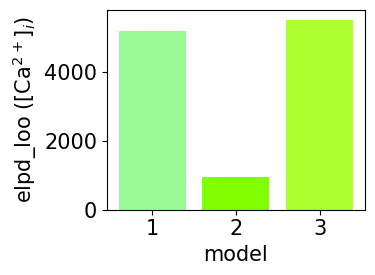

In [10]:
rcParams['figure.figsize']=4,3
rcParams['font.size']=15

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.set_xlabel('model')
ax1.set_ylabel('elpd_{} ([Ca$^2$$^+$]$_i$)'.format(ic))
xs=np.arange(1,nModels+1)
ax1.bar(xs,elpds_waic,color=['palegreen','chartreuse','greenyellow'])
    
plt.tight_layout()
plt.gcf().savefig('model_comparison_sim.png')